# Building a Neural Network for Klickwell Database

Loading the data and applying feature engineering to generate new features

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

horse_data = pd.read_csv("datacarreras.csv")

# Wins/Starts
horse_data['effect_jinete'] = round(horse_data["jinete_gana"] / horse_data["jinete_act"] * 100, 2)
horse_data['effect_trainer'] = round(horse_data["trainer_gana"] / horse_data["trainer_act"] * 100, 2)

# Filtering and replacing values

horse_data = horse_data.replace(np.inf, 30)
horse_data = horse_data[(horse_data.resultado != 0)]
horse_data["jinete_rep_mon"].replace(1, 0)
horse_data["jinete_rep_mon"].replace(3, 1)

# Amelioration of dividends with regards to last race
horse_data["mej_div"] = horse_data["penult_div"] - horse_data["ult_div"]

horse_data["distancia_pista"].value_counts()

1200    669
1300    425
1100    367
1400    353
1500     66
1800     58
1600     57
2400     23
1900     12
2000      8
Name: distancia_pista, dtype: int64

In [2]:
horse_data.head()

,fecha,numero_carrera,distancia_pista,grupo,nombre_caballo,tiempo,ult_div,penult_div,posicion,cuerpos_ult,...,lote,jinete_act,jinete_gana,jinete_rep_mon,trainer_act,trainer_gana,resultado,effect_jinete,effect_trainer,mej_div
0,08-11-2020,1,1800,2,ironhide,113.0,2100,2300,2,4.25,...,2,122,16,3,49,5,6,13.11,10.20,200
1,08-11-2020,1,1800,2,el ferretero,114.2,10000,10000,7,11.25,...,3,69,1,1,50,0,3,1.45,0.00,0
2,08-11-2020,1,1800,2,matheew star,115.0,350,350,5,6.50,...,3,43,5,3,93,8,4,11.63,8.60,0
3,08-11-2020,1,1800,2,power indy,113.3,450,600,3,6.50,...,3,99,14,1,146,19,1,14.14,13.01,150
4,08-11-2020,1,1800,2,gran giacomo,115.2,540,540,1,0.00,...,1,92,23,1,31,6,8,25.00,19.35,0


In [3]:
horse_data["resultado"].value_counts()

3     207
1     205
2     204
5     196
4     196
6     191
7     185
8     166
9     146
10    127
11     90
12     71
13     39
14     15
Name: resultado, dtype: int64

In case the year in the date string is only two digits, run the following code

In [ ]:
data["fecha"] = data["fecha"].apply(lambda x: x[:6] + f"20{x[-2]}" if len(x) < 9 else x)
[i for i in data["fecha"]]

Filtering out some irrelevant data and replacing zeros with the mean value of he column

In [4]:
horse_data = horse_data[['distancia_pista', 'tiempo', 'penult_div','ult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'jinete_gana', 'effect_jinete', 'jinete_rep_mon', 'trainer_gana','effect_trainer', 'resultado']]
horse_data["ult_div"].replace(0, horse_data["ult_div"].mean(axis=0), inplace=True)
horse_data["mej_div"].replace(0, horse_data["mej_div"].mean(axis=0), inplace=True)
horse_data.head()

/home/Nj1991/.local/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/Nj1991/.local/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,distancia_pista,tiempo,penult_div,ult_div,mej_div,posicion,cuerpos_ult,distancia_c,lote,jinete_gana,effect_jinete,jinete_rep_mon,trainer_gana,effect_trainer,resultado
0,1800,113.0,2300,2100.0,200.000000,2,4.25,2,2,16,13.11,3,5,10.20,6
1,1800,114.2,10000,10000.0,-149.041708,7,11.25,1,3,1,1.45,1,0,0.00,3
2,1800,115.0,350,350.0,-149.041708,5,6.50,2,3,5,11.63,3,8,8.60,4
3,1800,113.3,600,450.0,150.000000,3,6.50,3,3,14,14.14,1,19,13.01,1
4,1800,115.2,540,540.0,-149.041708,1,0.00,2,1,23,25.00,1,6,19.35,8


Any result over 6 gets put in the 6 category which could be called losers, since there are a lot of values the neural network would just pradict as much 6s as possible so better leave this out for the moment until finding a workaround for this.

In [5]:
#horse_data['resultado'] -= 1

#for i in horse_data['resultado']:
#    if i > 6:
#        horse_data['resultado'].replace(i, 6, inplace=True)
        
horse_data

,distancia_pista,tiempo,penult_div,ult_div,mej_div,posicion,cuerpos_ult,distancia_c,lote,jinete_gana,effect_jinete,jinete_rep_mon,trainer_gana,effect_trainer,resultado
0,1800,113.0,2300,2100.0,200.000000,2,4.25,2,2,16,13.11,3,5,10.20,6
1,1800,114.2,10000,10000.0,-149.041708,7,11.25,1,3,1,1.45,1,0,0.00,3
2,1800,115.0,350,350.0,-149.041708,5,6.50,2,3,5,11.63,3,8,8.60,4
3,1800,113.3,600,450.0,150.000000,3,6.50,3,3,14,14.14,1,19,13.01,1
4,1800,115.2,540,540.0,-149.041708,1,0.00,2,1,23,25.00,1,6,19.35,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,1200,74.4,240,160.0,80.000000,3,0.50,3,3,1,7.14,1,21,22.83,2
2148,1200,76.2,8300,8300.0,-149.041708,5,8.50,3,3,16,13.91,1,3,14.29,7
2149,1200,77.0,600,10000.0,-9400.000000,5,8.50,1,3,5,14.71,3,28,14.51,9
2150,1200,76.0,800,800.0,-149.041708,2,4.25,3,3,1,3.57,3,4,14.29,3


Divide the races by distances, separating long distance races and short distance into 2 separate groups of data. Horses in Venezuela are prone to lose in long distance races if they have only ran races bellow 1200 mts. Also, the neural network will only get input for the horses that arrived in the first 5 positions, since the program Klickwell already has a good percentage of having the winning horse in its 4 picks.

And make a category for generating a stratified sampling of the data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

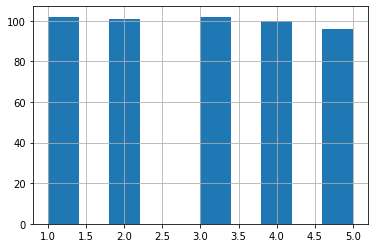

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

carreras_1200 = horse_data.loc[horse_data['distancia_pista'] <= 1200]
carreras_1200_gana = carreras_1200.loc[horse_data['resultado'] <= 5]
carreras_1300_plus = horse_data.loc[horse_data['distancia_pista'] >=1300]
carreras_1300_plus_gana = carreras_1300_plus.loc[horse_data['resultado'] <= 5]

carreras_1200_gana["resultado_cat"] = pd.cut(carreras_1200_gana["resultado"], bins=[0., 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5])
carreras_1300_plus_gana["resultado_cat"] = pd.cut(carreras_1300_plus_gana["resultado"], bins=[0., 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5])

carreras_1300_plus_gana["resultado_cat"].hist()

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(carreras_1200_gana, carreras_1200_gana["resultado_cat"]):
    carreras_1200_train_strat = carreras_1200_gana.iloc[train_index]
    carreras_1200_test_strat = carreras_1200_gana.iloc[test_index]
    
for train_index, test_index in split.split(carreras_1300_plus_gana, carreras_1300_plus_gana["resultado_cat"]):
    carreras_1300_train_strat = carreras_1300_plus_gana.iloc[train_index]
    carreras_1300_test_strat = carreras_1300_plus_gana.iloc[test_index]

In [8]:
carreras_1300_test_strat["resultado_cat"].value_counts() / len(carreras_1300_test_strat)

1    0.215686
5    0.196078
4    0.196078
3    0.196078
2    0.196078
Name: resultado_cat, dtype: float64

In [9]:
for set_ in (carreras_1200_train_strat, carreras_1200_test_strat):
    set_.drop("resultado_cat", axis=1, inplace=True)
    
for set_ in (carreras_1300_train_strat, carreras_1300_test_strat):
    set_.drop("resultado_cat", axis=1, inplace=True)

/home/Nj1991/.local/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Looking at the correlations

In [10]:
horse_corr_matrix_1300_plus = carreras_1300_plus_gana.corr()
horse_corr_matrix_1300_plus['resultado'].sort_values(ascending=True)

effect_jinete     -0.163734
distancia_c       -0.124367
lote              -0.093244
effect_trainer    -0.049461
jinete_gana       -0.040645
trainer_gana      -0.029088
mej_div           -0.012923
distancia_pista   -0.003564
jinete_rep_mon     0.012652
tiempo             0.017820
cuerpos_ult        0.191472
penult_div         0.209795
ult_div            0.221355
posicion           0.249691
resultado          1.000000
Name: resultado, dtype: float64

In [11]:
horse_corr_matrix_1200 = carreras_1200_gana.corr()
horse_corr_matrix_1200['resultado'].sort_values(ascending=True)

effect_jinete     -0.165645
distancia_c       -0.139594
mej_div           -0.078218
trainer_gana      -0.073310
jinete_rep_mon    -0.065842
jinete_gana       -0.064347
distancia_pista   -0.024939
effect_trainer    -0.015968
lote              -0.001763
tiempo             0.041122
penult_div         0.176138
cuerpos_ult        0.208185
posicion           0.236805
ult_div            0.246687
resultado          1.000000
Name: resultado, dtype: float64

Seems like position, bodies, dividends and effectiveness of the jokey and trainer have some correlation in both datasets, although not high enough. Next, in the results column, substract one, since keras to_categorical gives of an error if there is no zero value. (Keras Version 2.3.0)

In [12]:
carreras_1200_train_strat['resultado'] -= 1
carreras_1300_train_strat['resultado'] -= 1

carreras_1200_r = carreras_1200_train_strat["resultado"].copy()
carreras_1300_plus_r = carreras_1300_train_strat["resultado"].copy()

carreras_1200_train_strat.drop("resultado", axis=1)
carreras_1300_train_strat.drop("resultado", axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,distancia_pista,tiempo,penult_div,ult_div,mej_div,posicion,cuerpos_ult,distancia_c,lote,jinete_gana,effect_jinete,jinete_rep_mon,trainer_gana,effect_trainer
96,1400,89.2,2100,300.0,1800.000000,3,4.75,2,3,2,11.76,3,22,21.36
1379,1400,89.2,1200,2900.0,-1700.000000,3,6.25,3,3,3,4.92,3,0,0.00
610,1600,99.4,3800,900.0,2900.000000,5,25.00,2,3,13,12.87,1,23,13.94
970,1300,81.2,3500,3500.0,-149.041708,6,6.50,2,3,15,12.50,3,18,13.85
215,1300,81.3,800,1400.0,-600.000000,4,5.25,3,2,4,8.00,1,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,1400,88.2,10000,10000.0,-149.041708,7,6.25,2,3,1,3.85,1,13,13.13
1553,1300,81.1,700,700.0,-149.041708,4,8.00,1,3,16,13.91,3,21,22.83
1972,1600,100.3,1760,1760.0,-149.041708,6,10.25,1,1,4,14.29,3,3,13.04
248,1300,79.2,550,550.0,-149.041708,5,7.25,3,3,13,10.08,1,6,10.00


Pick the values that might yield some positive results.

In [13]:
carreras_1200_prepared = carreras_1200_train_strat[['distancia_pista', 'tiempo', 'ult_div', 'penult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]
carreras_1300_prepared = carreras_1300_train_strat[['distancia_pista', 'tiempo', 'ult_div', 'penult_div', 'mej_div','posicion','cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]

In [14]:
carreras_1300_plus_r.value_counts()

2    92
1    91
0    91
3    90
4    86
Name: resultado, dtype: int64

Use Scikit-Learn StandardScaler to scale the data since some features are in a diferent scale from others.

In [15]:
import keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

transform_data = Pipeline([
    ("scaler", StandardScaler())
])

X_1200, X_1200_val, y_1200, y_1200_val = train_test_split(carreras_1200_prepared, carreras_1200_r, test_size=0.1, random_state=42)
X_1300, X_1300_val, y_1300, y_1300_val = train_test_split(carreras_1300_prepared, carreras_1300_plus_r, test_size=0.1, random_state=42)

y_1200 = keras.utils.to_categorical(np.array(y_1200))
y_1300 = keras.utils.to_categorical(np.array(y_1300))

y_1200_val = keras.utils.to_categorical(np.array(y_1200_val))
y_1300_val = keras.utils.to_categorical(np.array(y_1300_val))

y_test_1200 = carreras_1200_test_strat["resultado"].copy()
y_test_1300 = carreras_1300_test_strat["resultado"].copy()

X_test_1200 = carreras_1200_test_strat[['distancia_pista', 'tiempo', 'ult_div', 'penult_div', 'mej_div','posicion', 'cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]
X_test_1300 = carreras_1300_test_strat[['distancia_pista', 'tiempo', 'ult_div', 'penult_div', 'mej_div','posicion', 'cuerpos_ult', 'distancia_c', 'lote', 'effect_jinete', 'jinete_rep_mon', 'effect_trainer']]

X_1200 = transform_data.fit_transform(X_1200)
X_1300 = transform_data.fit_transform(X_1300)

X_1200_val = transform_data.fit_transform(X_1200_val)
X_1300_val = transform_data.fit_transform(X_1300_val)

X_test_1200 = transform_data.fit_transform(X_test_1200)
X_test_1300 = transform_data.fit_transform(X_test_1300)

Using Theano backend.


In [16]:
print(f"{X_1300.shape}")
print(f"{y_1300.shape}")

(405, 12)
(405, 5)


# Sequential Dense layers model

An standard model to test. Added some weight regularizers to fight overfitting, also tried Dropout layers, but with no good results.

In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.1),input_shape=(12,)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.3),
    #keras.layers.Dense(32, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(48, activation="relu",kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.BatchNormalization(),
    #keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(5, activation="softmax")
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                416       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 48)                1584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 245       
Total params: 2,565
Trainable params: 2,405
Non-trainable params: 160
_________________________________________________________________


# Sequential ConvNet1D model (To Do)

Will need to reshape the data so a ConvNet1D model can read it, at the moment will stick to the standard model.

In [ ]:
#X_1300 = np.expand_dims(X_1300, axis=0)

model = keras.models.Sequential([
    keras.layers.Conv1D(32, 2,input_shape=(None, X_1300.shape[-1])),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(32, 1, activation='relu'),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

model.summary()

In [ ]:
#X_1300_val = np.expand_dims(X_1300_val, axis=0)

X_1300.shape
X_1300_val.shape

In [33]:
history = model.fit(X_1300, y_1300, epochs=120, validation_data=(X_1300_val, y_1300_val), callbacks=[keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)])
print("Done")

Train on 405 samples, validate on 45 samples
Epoch 1/120
405/405 [==============================] - 0s 574us/step - loss: 6.8865 - accuracy: 0.1877 - val_loss: 5.7173 - val_accuracy: 0.2222
Epoch 2/120
405/405 [==============================] - 0s 625us/step - loss: 4.9883 - accuracy: 0.2444 - val_loss: 4.1131 - val_accuracy: 0.2444
Epoch 3/120
405/405 [==============================] - 0s 386us/step - loss: 3.5116 - accuracy: 0.3235 - val_loss: 3.0378 - val_accuracy: 0.2667
Epoch 4/120
405/405 [==============================] - 0s 492us/step - loss: 2.6091 - accuracy: 0.3185 - val_loss: 2.4275 - val_accuracy: 0.2222
Epoch 5/120
405/405 [==============================] - 0s 553us/step - loss: 2.1953 - accuracy: 0.3383 - val_loss: 2.1245 - val_accuracy: 0.2222
Epoch 6/120
405/405 [==============================] - 0s 427us/step - loss: 2.0381 - accuracy: 0.3062 - val_loss: 2.0168 - val_accuracy: 0.2222
Epoch 7/120
405/405 [==============================] - 0s 427us/step - loss: 1.9454 -

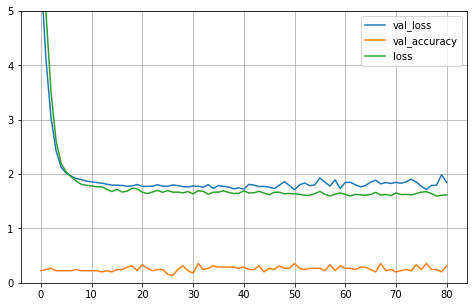

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid()
plt.legend()
plt.gca().set_ylim(0, 5)
plt.show()

In [24]:
y_test_1300 -= 1

y_test_1300 = keras.utils.to_categorical(y_test_1300)

In [35]:
model.evaluate(X_test_1300, y_test_1300)

51/51 [==============================] - 0s 264us/step


[1.8537062219544953, 0.27450981736183167]

In [36]:
y_proba = model.predict(X_test_1300)

print(f"{y_proba[5:10].round(2)}")
print(f"Labels: {y_test_1300[5:10]}")

[[0.08 0.13 0.28 0.19 0.33]
 [0.06 0.11 0.2  0.42 0.21]
 [0.21 0.1  0.26 0.17 0.25]
 [0.39 0.22 0.13 0.12 0.14]
 [0.33 0.09 0.21 0.11 0.25]]
Labels: [[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


After adding more data and training the model, the accuracy for the validation set and the test set increased from ~20% to ~30%, after only 80 epochs, the val_accuracy is still increasing.